## CNN Applications

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

### Example of Simple CNN with Image Augmentation

In [ ]:
# Define image augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Define normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


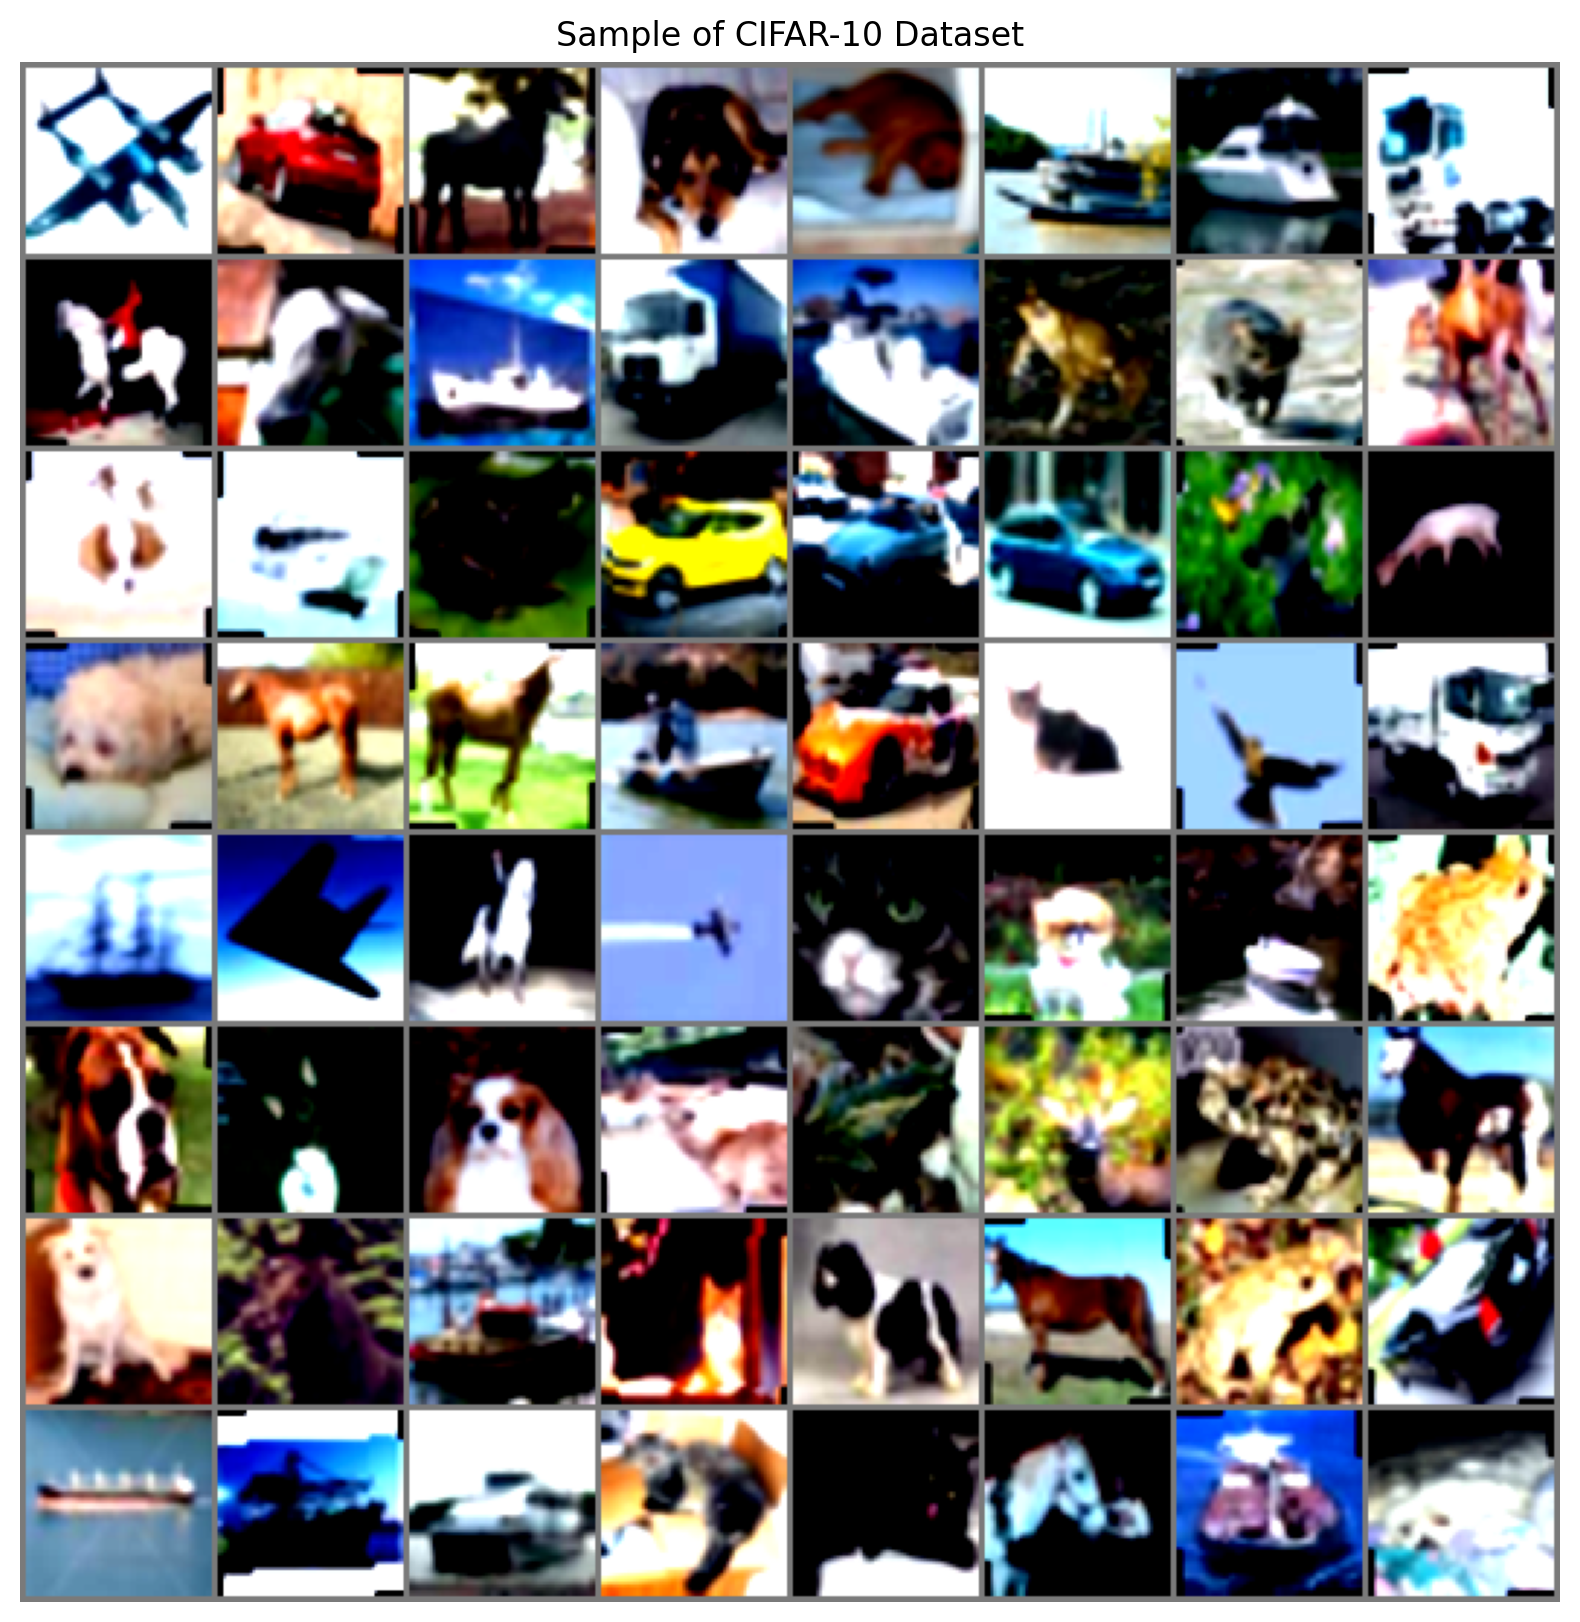

First Label: plane


In [ ]:
# Function to display images
def imshow(img, label):
    img = img / 2 + 0.48  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np.clip(npimg,0,1), (1, 2, 0)))
    plt.title('Sample of CIFAR-10 Dataset')
    plt.axis('off')
    #plt.title(f'First Item: {class_names[label]}')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images), labels[0])

# Display the name of the label for the first image in the batch
print(f'First Label: {classes[labels[0]]}')

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 40, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(40, 80, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(80 * 8 * 8, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.silu(self.conv1(x)))
        x = self.pool(F.silu(self.conv2(x)))
        x = x.view(-1, 80 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = SimpleCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

NameError: name 'net' is not defined

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()  # Set the model back to training mode
    return 100 * correct / total

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):  # Loop over the dataset multiple times

    running_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    with tqdm(total=len(trainloader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate running loss
            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (i + 1))
            pbar.update(1)

        # Calculate accuracies
        train_accuracy = calculate_accuracy(trainloader, net)
        test_accuracy = calculate_accuracy(testloader, net)

        # Print statistics
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(trainloader):.3f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')

Epoch 1/1: 100%|██████████| 782/782 [01:16<00:00, 10.18batch/s, loss=1.21]

Epoch 1/1, Loss: 1.207, Train Accuracy: 67.07%, Test Accuracy: 66.42%
Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        net.eval()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 77.52%


### Example with AlexNet

In [ ]:
# Define image augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Define normalization for testing
transform_test = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
num_classes = 10
net = AlexNet(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):  # Loop over the dataset multiple times

    running_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    with tqdm(total=len(trainloader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate running loss
            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (i + 1))
            pbar.update(1)

        # Calculate accuracies
        train_accuracy = calculate_accuracy(trainloader, net)
        test_accuracy = calculate_accuracy(testloader, net)

        # Print statistics
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(trainloader):.3f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')

#### Example with Dense Net design

<figure>
<center>
<img src='https://i.imgur.com/jAnP58k.png'width='800px'/>
<figcaption>Dense Net Computational Diagram</figcaption></center>
</figure>

#### Main Idea

1. **Dense Blocks**: The core component of DenseNet is the dense block. Within each dense block, each layer receives the feature maps from all preceding layers as inputs, and passes its own feature maps to all subsequent layers. This results in a dense connectivity pattern.

2. **Bottleneck Layers**: To improve computational efficiency, DenseNet uses bottleneck layers (1x1 convolutions) within the dense blocks. These layers reduce the number of input feature maps before passing them through 3x3 convolutions.

3. **Transition Layers**: Between dense blocks, transition layers are used to reduce the size of feature maps and the number of feature maps. These layers consist of a batch normalization layer, a 1x1 convolutional layer, and a 2x2 average pooling layer.

4. **Growth Rate**: The growth rate (k) is a hyperparameter that refers to the number of output feature maps each layer in a dense block produces. For DenseNet-121, the growth rate is typically 32.

#### Architecture of DenseNet-121

DenseNet-121 consists of:
- An initial convolutional layer
- Four dense blocks
- Three transition layers between the dense blocks
- A classification layer at the end

Here's a breakdown of the architecture:

1. **Initial Convolution**:
    - 7x7 Convolution with stride 2
    - Batch Normalization
    - ReLU activation
    - 3x3 Max Pooling with stride 2

2. **Dense Block 1**:
    - 6 layers, each with bottleneck (1x1 convolution) and 3x3 convolution

3. **Transition Layer 1**:
    - Batch Normalization
    - 1x1 Convolution
    - 2x2 Average Pooling with stride 2

4. **Dense Block 2**:
    - 12 layers, each with bottleneck (1x1 convolution) and 3x3 convolution

5. **Transition Layer 2**:
    - Batch Normalization
    - 1x1 Convolution
    - 2x2 Average Pooling with stride 2

6. **Dense Block 3**:
    - 24 layers, each with bottleneck (1x1 convolution) and 3x3 convolution

7. **Transition Layer 3**:
    - Batch Normalization
    - 1x1 Convolution
    - 2x2 Average Pooling with stride 2

8. **Dense Block 4**:
    - 16 layers, each with bottleneck (1x1 convolution) and 3x3 convolution

9. **Classification Layer**:
    - Batch Normalization
    - ReLU activation
    - Global Average Pooling
    - Fully Connected Layer (output size depends on the number of classes, typically 1000 for ImageNet)

#### Summary of Layers

- **Convolutional Layer (7x7)**: 1 layer
- **Dense Blocks**: 4 blocks (6 layers, 12 layers, 24 layers, 16 layers)
- **Transition Layers**: 3 layers
- **Classification Layer**: 1 layer

#### Visualization of DenseNet-121

```plaintext
Input Image
   |
7x7 Conv, Stride 2
   |
3x3 Max Pool, Stride 2
   |
Dense Block 1
   |
Transition Layer 1
   |
Dense Block 2
   |
Transition Layer 2
   |
Dense Block 3
   |
Transition Layer 3
   |
Dense Block 4
   |
Global Average Pool
   |
Fully Connected (Softmax)
   |
Output (Class Probabilities)
```

DenseNet-121's design ensures that each layer has direct access to the gradients from the loss function and the original input signal, which improves gradient flow and efficiency of parameter usage, ultimately leading to better performance and robustness in training deep neural networks.

<figure>
<center>
<img src='https://i.imgur.com/EiKYqa2.png'width='800px'/>
<figcaption>Dense Net Convolutions</figcaption></center>
</figure>





In [ ]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Split train dataset into train and validation
validation_split = 0.1
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(validation_split * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),  # Resize to 224x224 for DenseNet
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for DenseNet
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Custom Dataset class to apply transformations
class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CIFAR10Dataset(train_dataset, train_idx, transform=transform_train)
val_dataset = CIFAR10Dataset(torchvision.datasets.CIFAR10(root='./data', train=True, download=True), val_idx, transform=transform_test)
test_dataset = CIFAR10Dataset(test_dataset, list(range(len(test_dataset))), transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from torchvision.models import densenet121

# Load pre-trained DenseNet121 and modify it for CIFAR-10
model = densenet121(pretrained=True)

# Replace the classifier
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

        validate_model(model, val_loader)

def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20)

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

test_model(model, test_loader)


Epoch [1/10], Loss: 0.8287
Validation Accuracy: 78.60%
Epoch [2/10], Loss: 0.7081
Validation Accuracy: 80.72%
Epoch [3/10], Loss: 0.6709
Validation Accuracy: 81.18%
Epoch [4/10], Loss: 0.6391
Validation Accuracy: 80.90%
Epoch [5/10], Loss: 0.6172
Validation Accuracy: 82.90%
Epoch [6/10], Loss: 0.5991
Validation Accuracy: 82.48%
Epoch [7/10], Loss: 0.5815
Validation Accuracy: 82.78%
Epoch [8/10], Loss: 0.5780
Validation Accuracy: 82.80%
Epoch [9/10], Loss: 0.5616
Validation Accuracy: 82.44%
Epoch [10/10], Loss: 0.5620
Validation Accuracy: 82.90%
Epoch [1/20], Loss: 0.3187
Validation Accuracy: 92.54%
Epoch [2/20], Loss: 0.2062
Validation Accuracy: 93.88%
Epoch [3/20], Loss: 0.1641
Validation Accuracy: 94.46%
Epoch [4/20], Loss: 0.1389
Validation Accuracy: 95.08%
Epoch [5/20], Loss: 0.1220
Validation Accuracy: 95.42%
Epoch [6/20], Loss: 0.1099
Validation Accuracy: 95.50%
Epoch [7/20], Loss: 0.0964
Validation Accuracy: 95.92%
Epoch [8/20], Loss: 0.0880
Validation Accuracy: 96.02%
Epoch [9/